In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

## Reading in Data and housekeeping

In [9]:
accounts = pd.read_csv('account_dat.csv')
apps=pd.read_csv('app_dat.csv')
in_app_cont=pd.read_csv('in-app_dat.csv')
devices=pd.read_csv('device_ref.csv')
categories=pd.read_csv('category_ref.csv')
trans=pd.read_csv('transaction_dat.csv')

accounts.create_dt = pd.to_datetime(accounts.create_dt)
trans.create_dt = pd.to_datetime(trans.create_dt)

# Create year_month to analyze trends across time
accounts['year_mon_account'] = pd.to_datetime(accounts.create_dt).dt.to_period('M')
trans['year_mon_trans'] = pd.to_datetime(trans.create_dt).dt.to_period('M')

#rename vars to more logical names
accounts=accounts.rename(columns={'create_dt':'act_create_dt'})
categories=categories.rename(columns={'category_name':'app_category'})
apps=apps.rename(columns={'content_id':'app_id'})
in_app_cont=in_app_cont.rename(columns={'parent_app_content_id':'app_id','type':'content_type'})
trans=trans.rename(columns={'device_id':'purchase_device_id', 'create_dt':'trans_dt'})

## Looking at accounts data

In [10]:
accounts.head()

,acct_id,act_create_dt,payment_type,year_mon_account
0,eb23e449d274bddb,2012-04-03,PMOF,2012-04
1,3d60dcb8494a0d70,2009-08-31,PMOF,2009-08
2,9b6d6fbf76504d85,2008-11-06,PMOF,2008-11
3,343255370828b380,2012-01-03,PMOF,2012-01
4,664e27f05189c387,2010-10-31,PMOF,2010-10


In [16]:
accounts.groupby('payment_type').acct_id.nunique()

payment_type
Free only    50000
PMOF         50000
Name: acct_id, dtype: int64

<AxesSubplot:title={'center':'Accounts across Time'}, xlabel='year_mon_account'>

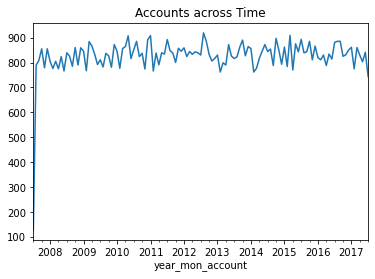

In [11]:
accounts.groupby('year_mon_account').acct_id.count().plot(title='Accounts across Time')

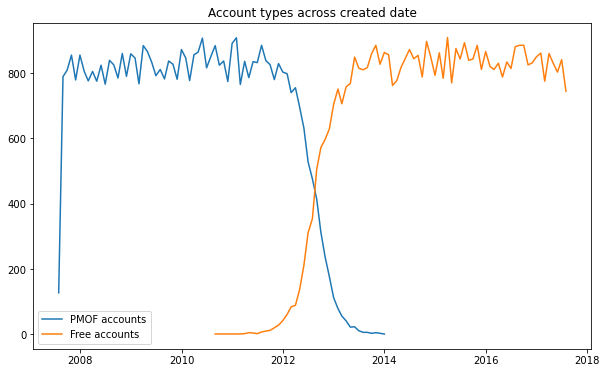

In [13]:
pd.plotting.register_matplotlib_converters()
series1_y=accounts[accounts.payment_type=='PMOF'].groupby('year_mon_account').acct_id.count().values
series1_x=accounts[accounts.payment_type=='PMOF'].groupby('year_mon_account').acct_id.count().index.values.astype('datetime64[ns]')


series2_y=accounts[accounts.payment_type=='Free only'].groupby('year_mon_account').acct_id.count().values
series2_x=accounts[accounts.payment_type=='Free only'].groupby('year_mon_account').acct_id.count().index.values.astype('datetime64[ns]') 

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(series1_x,series1_y, label='PMOF accounts')
plt.plot(series2_x,series2_y, label='Free accounts')

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend()
plt.title('Account types across created date')
plt.show()

### Finding
- 100k accounts have been provided with 50k free accounts and 50k accounts with PMOF
- Accounts with PMOF decline in 2013 and similarly free accounts start after 2013
- This might be due to a change in option requiring PMOF to create accounts before 2013 or probably is just due to the way data is pulled

## Looking at Transactions

In [14]:
trans.head()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,2016-08
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,2016-09
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,2016-08
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,2016-06
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,2016-06


<AxesSubplot:title={'center':'Transactions/Downloads across time'}, xlabel='year_mon_trans'>

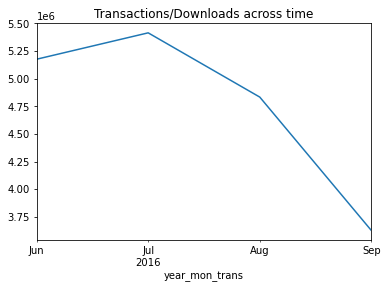

In [15]:
trans.groupby('year_mon_trans').price.sum().plot(title='Transactions/Downloads across time')

#### Distribution of transaction $ value

<AxesSubplot:>

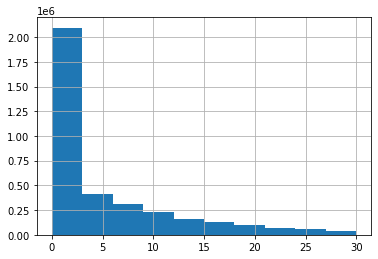

In [55]:
trans.price.hist()

<AxesSubplot:>

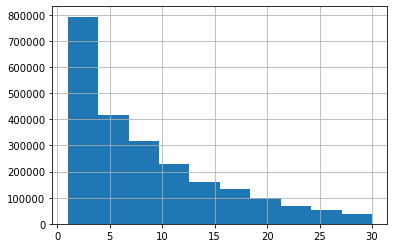

In [56]:
# Non zero transactions distribution
trans[trans.price>0].price.hist()

In [64]:
# Percent zero transactions
print('Percent transactions that are free: ' + str(round(sum(trans.price==0)/trans.shape[0],2)))

Percent transactions that are free: 0.36


#### Percent Transactions across devices

Text(0.5, 1.0, 'Split of transactions across Devices')

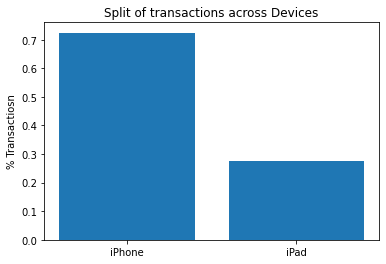

In [47]:
total_trans=trans.shape[0]
y=(trans.groupby('purchase_device_id').purchase_device_id.count().values)/total_trans
x=trans.groupby('purchase_device_id').purchase_device_id.count().index
plt.bar(x,y)
plt.xticks([1,2],['iPhone','iPad'])
plt.ylabel('% Transactiosn')
plt.title('Split of transactions across Devices')
# print(trans.groupby('purchase_device_id').acct_id.nunique())
# trans.acct_id.nunique()


In [80]:
print('%age transactiosn on iphone: '+ str(y[0]))
print('%age transactiosn on ipad: '+ str(y[1]))

%age transactiosn on iphone: 0.7246983999208318
%age transactiosn on ipad: 0.2753016000791682


#### Accounts with tranascations/downloads across one/multiple devices

In [74]:
acct_dev=pd.DataFrame(trans.groupby('acct_id').purchase_device_id.nunique()).reset_index()
acct_dev.head()

,acct_id,purchase_device_id
0,00028709c8d435ff,2
1,0005a4d77127fde7,2
2,0005c296f2605c08,2
3,00082ad3dc50a70d,2
4,00085ff73786df4d,2


In [75]:
acct_dev.groupby('purchase_device_id').count()

,acct_id
purchase_device_id,
2,30000


### Finding
- Transactions/Downloads for 30k accounts has been provided
- All transactions/downloads are between June 2016 and Sep 2016
- Transaction/Download counts have a left skew as expected
- Most transactions happen on iphone(72.5%) than ipad(27.5%)
- All accounts with transactions have both iPhone and ipad

## Looking at apps

In [82]:
apps.head()

,app_name,app_id,category_id,device_id
0,half-slouched having,22dfac9721b899cb,Y-8,3
1,lift whale-ships,7c645810cd7f166e,M-7,3
2,mightily community,c495bcb878faffaa,Y-8,2
3,session: too--shall,4e683dcd461cdd22,Y-8,1
4,That Zoology,6473dd29a2badbf1,Y-8,3


In [85]:
categories.head()

,app_category,category_id
0,Games,Z-1
1,Social Networking,Q-5
2,Utilities,M-7
3,Entertainment,Q-1
4,Photos & Videos,Y-8


In [91]:
# Map apps and categories
apps_cat=pd.merge(apps,categories,on='category_id').drop(columns=['category_id'])

In [92]:
apps_cat.head()

,app_name,app_id,device_id,app_category
0,half-slouched having,22dfac9721b899cb,3,Photos & Videos
1,mightily community,c495bcb878faffaa,2,Photos & Videos
2,session: too--shall,4e683dcd461cdd22,1,Photos & Videos
3,That Zoology,6473dd29a2badbf1,3,Photos & Videos
4,careful!--come stubbornly,ee013dcbf9ecc2b1,3,Photos & Videos


app_category
Entertainment        149
Games                392
Photos & Videos      260
Social Networking     46
Utilities            153
Name: app_id, dtype: int64


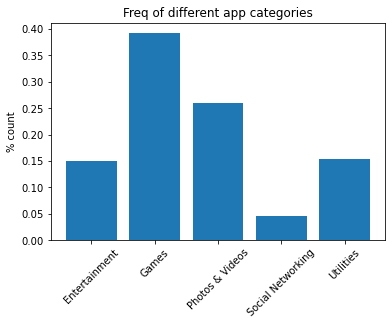

In [103]:
apps_freq=apps_cat.groupby('app_category').app_id.count()

y=(apps_freq.values)/1000
x=apps_freq.index
plt.bar(x,y)
plt.xticks(rotation=45)
plt.ylabel('% count')
plt.title('Freq of different app categories')
print(apps_freq)

#### In App content

In [104]:
in_app_cont.head()

,app_id,content_id,content_type
0,d2bde35599e0dae9,227227a77c59809b,consumable
1,d2bde35599e0dae9,41ac2362a2600185,consumable
2,d2bde35599e0dae9,64a8e16f030bb611,consumable
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable


In [109]:
in_app_cont.shape

(2376, 3)

In [111]:
in_app_cont.app_id.nunique()

476

#### Note : There are 1000 apps but in app content for 476 are present

In [110]:
print(in_app_cont.groupby('content_type').content_id.nunique())

content_type
consumable      2107
subscription     269
Name: content_id, dtype: int64


## Map apps to in_app_cont

In [170]:
# Checking if all apps in in_app_cont is present in apps table
len(set(in_app_cont.app_id.unique())-set(apps_wt_cont.app_id.unique()))

0

In [174]:
apps_wt_cont = pd.merge(apps_cat,in_app_cont,on='app_id',how='left')
#Outer join not needed as all apps in in_app_cont is present in apps table

In [175]:
apps_wt_cont.head()

,app_name,app_id,device_id,app_category,content_id,content_type
0,half-slouched having,22dfac9721b899cb,3,Photos & Videos,f049e141e84edd84,consumable
1,mightily community,c495bcb878faffaa,2,Photos & Videos,107aece323e389df,consumable
2,mightily community,c495bcb878faffaa,2,Photos & Videos,77389dc3f8108c77,consumable
3,session: too--shall,4e683dcd461cdd22,1,Photos & Videos,abfa638eb85a98f3,consumable
4,session: too--shall,4e683dcd461cdd22,1,Photos & Videos,5275949120266f44,consumable


In [178]:
apps_wt_cont.isnull().sum()

app_name          0
app_id            0
device_id         0
app_category      0
content_id      524
content_type    524
dtype: int64

#### Note: Only 476 apps have a content_id associated with them, therefore only 476 apps can be mapped to transactions/downloads

## Map apps and content to transaction/downloads data

In [256]:
trans_dev=pd.merge(trans,devices,left_on='purchase_device_id',right_on='device_id',how='left').drop(columns=['device_id'])
trans_master=pd.merge(trans_dev,apps_wt_cont.drop(columns=['device_id']),on='content_id',how='left')

In [184]:
trans_master.head()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans,device_name,app_name,app_id,app_category,content_type
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,2016-08,iPhone,events Bildad's,61cea77b9bc843d1,Utilities,subscription
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,2016-09,iPad,swell questionably,1f0ebd67df5846cd,Utilities,consumable
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,2016-08,iPad,supperless--my Shipmates,1383e4f2f49f0f44,Games,consumable
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,2016-06,iPad,unwritten hungry,8590a25d4e5c249c,Games,consumable
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,2016-06,iPad,Turning thanked,478e10f9248b7842,Entertainment,consumable


In [185]:
trans_master.isnull().sum()

trans_dt                    0
content_id                  0
acct_id                     0
price                       0
purchase_device_id          0
year_mon_trans              0
device_name                 0
app_name              1594364
app_id                1594364
app_category          1594364
content_type          1594364
dtype: int64

#### Note: About 1.6 million transactions are on apps that do not have app data 

In [195]:
apps_wt_cont.content_id.nunique()

2376

In [186]:
trans_master.content_id.nunique()

2913

In [193]:
# Are there content_ids in app table which do not map to transaction? 
set(apps_wt_cont.content_id.unique())-set(trans_master.content_id.unique())


{nan}

#### Note: There are 537 content_ids not in app data which accounts for 1.6 million downloads/transactions

## Explore Downloads and Payment data

In [196]:
trans_master.head()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans,device_name,app_name,app_id,app_category,content_type
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,2016-08,iPhone,events Bildad's,61cea77b9bc843d1,Utilities,subscription
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,2016-09,iPad,swell questionably,1f0ebd67df5846cd,Utilities,consumable
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,2016-08,iPad,supperless--my Shipmates,1383e4f2f49f0f44,Games,consumable
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,2016-06,iPad,unwritten hungry,8590a25d4e5c249c,Games,consumable
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,2016-06,iPad,Turning thanked,478e10f9248b7842,Entertainment,consumable


#### Freq of transactions across time across app_types

<AxesSubplot:title={'center':'Freq of transactions across time across app_types'}, xlabel='trans_dt'>

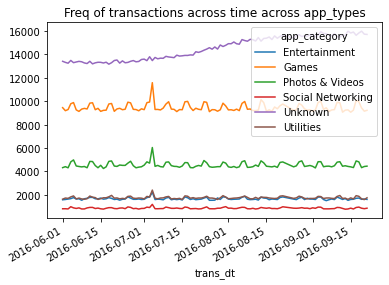

In [262]:
trans_freq_app_cat=pd.DataFrame(trans_master.fillna({'app_category':'Unknown'}).groupby(['app_category','trans_dt']).acct_id.count()).reset_index()
trans_freq_app_cat.pivot(index='trans_dt',columns='app_category',values='acct_id').plot(title='Freq of transactions across time across app_types')


#### Avg $ val of transactions across time across app_types

<AxesSubplot:title={'center':'avg $ val of transactions across time across app_types'}, xlabel='trans_dt'>

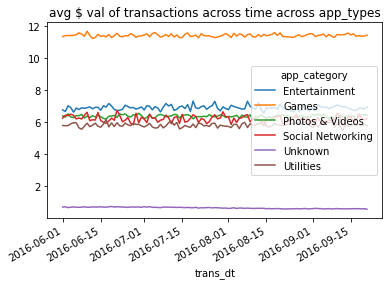

In [264]:
trans_freq_app_cat=pd.DataFrame(trans_master.fillna({'app_category':'Unknown'}).groupby(['app_category','trans_dt']).price.mean()).reset_index()
trans_freq_app_cat.pivot(index='trans_dt',columns='app_category',values='price').plot(title = 'avg $ val of transactions across time across app_types')


<AxesSubplot:title={'center':'Transaction volume across app types'}, xlabel='app_category'>

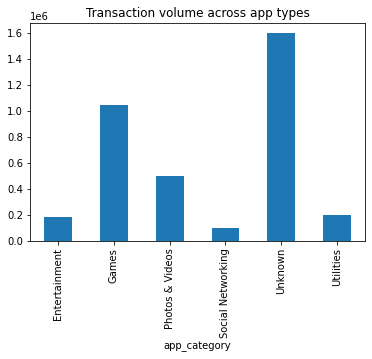

In [271]:
trans_master.fillna({'app_category':'Unknown'}).groupby('app_category').price.count().plot.bar(title='Transaction volume across app types')

#### Note: The transactions from the missing app data has the highest volume and quite low average transaction value

<AxesSubplot:title={'center':'Non zero transaction volume across app types'}, xlabel='app_category'>

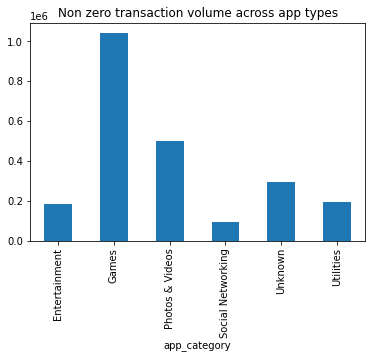

In [270]:
trans_master.fillna({'app_category':'Unknown'})[trans_master.price>0].groupby('app_category').price.count().plot.bar(title='Non zero transaction volume across app types')

#### Note: The volume of transactions which are >$0 have a smaller proportion of unknowns

<AxesSubplot:title={'center':'Transaction volume across content_type'}, xlabel='content_type'>

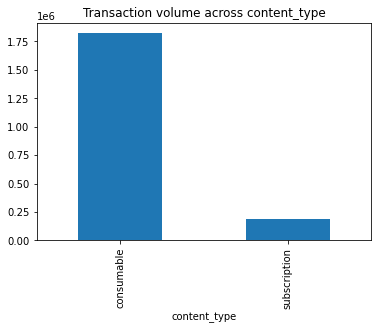

In [274]:
trans_master.groupby('content_type').price.count().plot.bar(title='Transaction volume across content_type')

<AxesSubplot:title={'center':'Non zero Transaction volume across content_type'}, xlabel='content_type'>

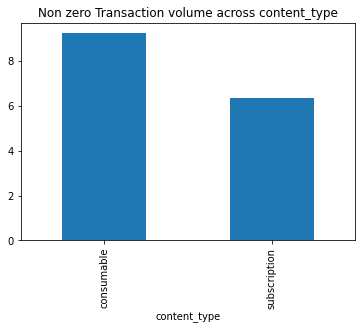

In [275]:
trans_master.groupby('content_type').price.mean().plot.bar(title='Non zero Transaction volume across content_type')

#### Check if there are any zero $ transaction which has app info?

In [283]:
trans_master[(trans_master.price==0) & ~(trans_master.app_id.isnull())]
# .groupby('content_type').price.mean()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans,device_name,app_name,app_id,app_category,content_type


In [433]:
sum((trans_master.price!=0) & (trans_master.app_id.isnull()))/trans_master.shape[0]

0.08098940293704049

#### 8% non zero transactions do not have app info 

In [309]:
len(set(trans_master.acct_id[trans_master.price!=0])-(set(trans_master.acct_id[trans_master.price==0])))

0

#### Finding: 
- Consumable transactions volume and avg tranasaction size are higher than subscription based transactions
- Any transaction which is of dollar 0 value has no app or app content info against it
- All accounts with transactions have a 0 transaction atleast once



## Map accounts to transactions(for all transactions with accounts present)

In [313]:
master=pd.merge(trans_master,accounts,on='acct_id',how='left')

In [314]:
master.head()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans,device_name,app_name,app_id,app_category,content_type,act_create_dt,payment_type,year_mon_account
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,2016-08,iPhone,events Bildad's,61cea77b9bc843d1,Utilities,subscription,2009-08-29,PMOF,2009-08
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,2016-09,iPad,swell questionably,1f0ebd67df5846cd,Utilities,consumable,2011-05-28,PMOF,2011-05
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,2016-08,iPad,supperless--my Shipmates,1383e4f2f49f0f44,Games,consumable,2009-11-15,PMOF,2009-11
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,2016-06,iPad,unwritten hungry,8590a25d4e5c249c,Games,consumable,2009-03-01,PMOF,2009-03
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,2016-06,iPad,Turning thanked,478e10f9248b7842,Entertainment,consumable,2010-10-01,PMOF,2010-10


In [320]:
master.isnull().sum()

trans_dt                    0
content_id                  0
acct_id                     0
price                       0
purchase_device_id          0
year_mon_trans              0
device_name                 0
app_name              1594364
app_id                1594364
app_category          1594364
content_type          1594364
act_create_dt            2742
payment_type             2742
year_mon_account         2742
age_on_pltfm             2742
dtype: int64

In [321]:
master[master.act_create_dt.isnull()].acct_id.nunique()

25

In [324]:
master[~master.act_create_dt.isnull()].acct_id.nunique()

29975

#### Note: 25 out of 30k accounts do not have a mapping to account created

### Create a new column as age on platform(transaction_dt- account_create_dt)

In [315]:
master['age_on_pltfm']=(master.trans_dt-master.act_create_dt).dt.days

<AxesSubplot:>

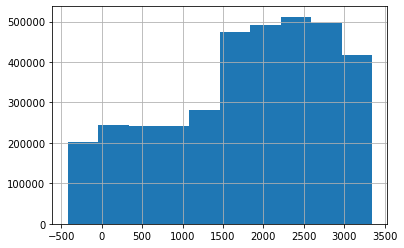

In [316]:
# the below histogram is on number of transactions and not accounts
master['age_on_pltfm'].hist()

#### Finding: There are accounts with account create dates after transactions 

In [340]:
sum(master.age_on_pltfm<0)/master.shape[0]

0.0647039272805695

In [339]:
master.acct_id[master.age_on_pltfm<0].nunique()/ 30000
# master.acct_id[master.age_on_pltfm<0].nunique()


0.11623333333333333

#### There are  6.4 % transactions by 11.6 % accounts  displaying -ve age on platform

In [355]:
master.head()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans,device_name,app_name,app_id,app_category,content_type,act_create_dt,payment_type,year_mon_account,age_on_pltfm
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,2016-08,iPhone,events Bildad's,61cea77b9bc843d1,Utilities,subscription,2009-08-29,PMOF,2009-08,2556.0
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,2016-09,iPad,swell questionably,1f0ebd67df5846cd,Utilities,consumable,2011-05-28,PMOF,2011-05,1938.0
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,2016-08,iPad,supperless--my Shipmates,1383e4f2f49f0f44,Games,consumable,2009-11-15,PMOF,2009-11,2465.0
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,2016-06,iPad,unwritten hungry,8590a25d4e5c249c,Games,consumable,2009-03-01,PMOF,2009-03,2665.0
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,2016-06,iPad,Turning thanked,478e10f9248b7842,Entertainment,consumable,2010-10-01,PMOF,2010-10,2082.0


In [438]:
master[master.price>0].groupby('payment_type').acct_id.nunique()

payment_type
PMOF    14982
Name: acct_id, dtype: int64

In [439]:
master[master.price==0].groupby('payment_type').acct_id.nunique()

payment_type
Free only    14993
PMOF         14982
Name: acct_id, dtype: int64

## User level dataset

In [447]:
user_dtst=master.groupby('acct_id').agg(
                                        tot_trans_val=('price', lambda x: sum(x)),        
                                        avg_trans_val=('price', 'mean'),
                                        trans_freq=('price', 'count'),
                                        uniq_categ=('app_category','nunique'),
                                        payment_type=('payment_type','min'),
                                        game_trans_count=('app_category', lambda x:sum(np.where(x=='Games',1,0)))
                                        ).reset_index()
user_dtst.head()

,acct_id,tot_trans_val,avg_trans_val,trans_freq,uniq_categ,payment_type,game_trans_count
0,00028709c8d435ff,0.00,0.000000,71,0,Free only,0
1,0005a4d77127fde7,1048.69,7.490643,140,5,PMOF,62
2,0005c296f2605c08,1208.55,7.899020,153,5,PMOF,62
3,00082ad3dc50a70d,0.00,0.000000,76,0,Free only,0
4,00085ff73786df4d,1255.51,7.946266,158,5,PMOF,81


### Payer non payer proportions in data

In [398]:
sum(user_dtst.tot_trans_val==0)/user_dtst.shape[0]

0.5002333333333333

#### Note: The dataset has 50% payers and 50% non payers

### Distribution of total spend across payers

<AxesSubplot:>

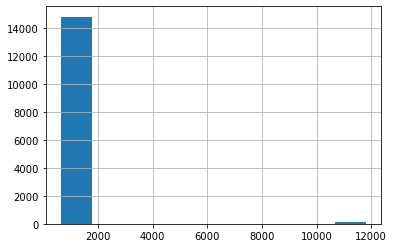

In [399]:
user_dtst[user_dtst.tot_trans_val>0].tot_trans_val.hist()

#### Outliers skew the distribution so creating 100 buckets based on total spend ranks

In [448]:
user_dtst['per_tot_spend']=user_dtst.tot_trans_val.rank(pct=True, method='dense')
user_dtst['per_tot_spend_100']=round(user_dtst.tot_trans_val.rank(pct=True, method='dense'),2)

<AxesSubplot:title={'center':'Total Spend for payers across 100 ranked buckets'}, xlabel='per_tot_spend_100'>

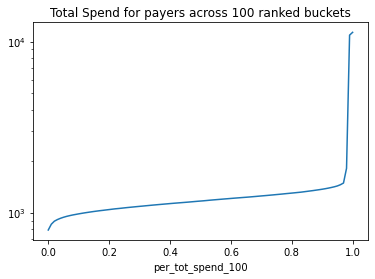

In [449]:
user_dtst[user_dtst.tot_trans_val>0].groupby('per_tot_spend_100').tot_trans_val.mean().plot(logy=True, title='Total Spend for payers across 100 ranked buckets')

#### Remove last 2 %ile and check distribution for payers

<AxesSubplot:>

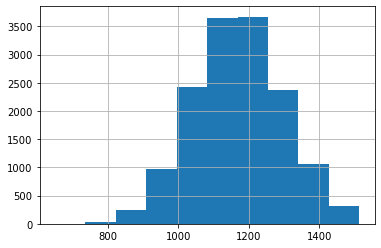

In [450]:
outlier_filter = user_dtst.per_tot_spend_100 < 0.98 
payer_filter = user_dtst.tot_trans_val>0
user_dtst[payer_filter & outlier_filter].tot_trans_val.hist()

#### Distribution of Whales

<AxesSubplot:>

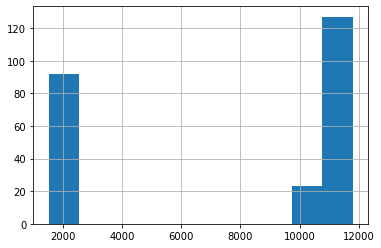

In [393]:
user_dtst[(user_dtst.per_tot_spend_100 >= 0.98) & (user_dtst.tot_trans_val>0)].tot_trans_val.hist()

#### Relationsip between Game apps and total spend

Text(0, 0.5, 'Total Spend')

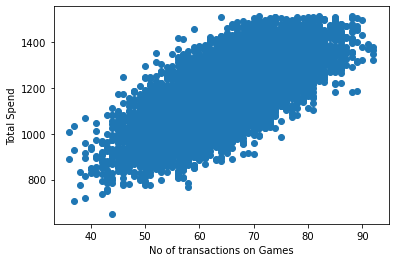

In [462]:
plt.scatter(x=user_dtst[outlier_filter & payer_filter].game_trans_count,y=user_dtst[outlier_filter & payer_filter].tot_trans_val)
plt.xlabel('No of transactions on Games')
plt.ylabel('Total Spend')

Text(0, 0.5, 'Total Spend')

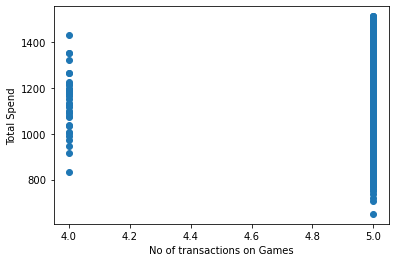

In [463]:
plt.scatter(x=user_dtst[outlier_filter & payer_filter].uniq_categ,y=user_dtst[outlier_filter & payer_filter].tot_trans_val)
plt.xlabel('No of transactions on Games')
plt.ylabel('Total Spend')